<a href="https://colab.research.google.com/github/alvinwalker314/DS-Unit-2-Regression-2/blob/master/Alvin%20Walker_Sprint_Challenge_8_Regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

In [0]:
!pip install pdpbox

In [0]:
!pip install category_encoders

In [0]:
!pip install eli5

In [0]:
import pandas as pd 
from xgboost import XGBRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
import numpy as np
from scipy.stats import randint, uniform
import category_encoders as ce
from eli5.sklearn import PermutationImportance
import eli5
import seaborn as sns

In [0]:
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
assert train.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## 1. Wrangle relational data, Log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [5]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,4,5,2015-07-31,13995,1498,1,1
1,8,5,2015-07-31,8492,833,1,1
2,11,5,2015-07-31,10457,1236,1,1
3,12,5,2015-07-31,8959,962,1,1
4,34,5,2015-07-31,11144,1162,1,1


In [6]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
1,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
2,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
3,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
4,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [7]:
train.shape, test.shape, store.shape

((78400, 7), (78400, 7), (200, 10))

In [0]:
train_set= pd.merge(train, store)

test_set= pd.merge(test, store)

In [63]:
train_set.shape, test_set.shape

((78400, 16), (78400, 16))

# Distribution before logging target

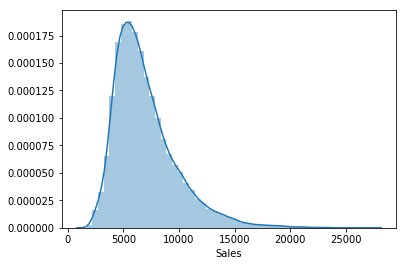

In [66]:
ax= sns.distplot(train_set['Sales'])

In [0]:
train_set['Sales']= np.log1p(train_set['Sales'])
test_set['Sales']= np.log1p(test_set['Sales'])

# Distribution after logging target

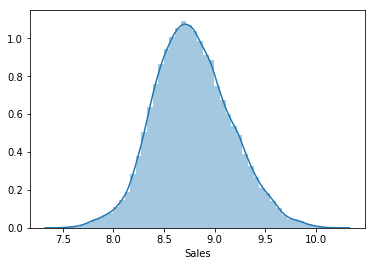

In [69]:
ax= sns.distplot(train_set['Sales'])

In [0]:
train_set=train_set.fillna(0)
test_set= test_set.fillna(0)

In [0]:
stores= train_set['Store'].unique()

In [0]:
train_stores, val_stores= train_test_split(stores, train_size=0.8, test_size= 0.2)

In [13]:
train_stores.shape, val_stores.shape

((80,), (20,))

In [0]:
train= train_set[train_set['Store'].isin(train_stores)]

val= train_set[train_set['Store'].isin(val_stores)]

In [15]:
train.shape, val.shape

((62720, 16), (15680, 16))

In [0]:
target= 'Sales'

train_target= train[target]
train_features= train.drop(columns=['Store', 'Sales'])

val_target= val[target]
val_features= val.drop(columns=['Store', 'Sales'])

In [17]:
train_features.shape, train_target.shape, val_features.shape, val_target.shape

((62720, 14), (62720,), (15680, 14), (15680,))

In [0]:
test_target= test_set[target]

test_features= test_set.drop(columns=['Store', 'Sales'])

In [19]:
test_features.shape, test_target.shape

((78400, 14), (78400,))

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all dates for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all dates for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all dates for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

# Model before hyperparameter optimization and feature reduction

In [0]:
encoder= ce.OrdinalEncoder()

train_encoded= encoder.fit_transform(train_features)

val_encoded= encoder.transform(val_features)

test_encoded= encoder.transform(test_features)

In [21]:
train_encoded.shape, val_encoded.shape, test_encoded.shape

((62720, 14), (15680, 14), (78400, 14))

In [0]:
model= XGBRegressor(num_estimators=1000, random_state=42, n_jobs=-1)

In [33]:
model.fit(train_encoded, train_target)

[17:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, num_estimators=1000,
             objective='reg:linear', random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

In [0]:
val_pred= model.predict(val_encoded)

In [35]:
val_features.shape, val_target.shape, val_pred.shape

((15680, 14), (15680,), (15680,))

In [36]:
rsmle= np.sqrt(mean_squared_error(val_target, val_pred))

r_squared= r2_score(val_target, val_pred)

print(f'RMSLE: {rsmle}\nR2 score:{r_squared}')

RMSLE: 0.18326244119648497
R2 score:0.7694980162058731


In [37]:
param_distributions = {
    'XGBRegressor__n_estimators': randint(100, 1000),
    'XGBRegressor__booster': ['gbtree', 'gblinear', 'dart'],
    'XGBRegressor__max_depth': randint(3, 10)
}

search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=3,
    cv=3,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1
)

groups= train_encoded['Date']
search.fit(train_encoded, train_target , groups=groups)

[17:42:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          num_estimators=1000,
                                          objective='...
                   param_distributions={'XGBRegressor__booster': ['gbtree',
                                                                  'gblinear',
                                   

In [38]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'XGBRegressor__booster': 'dart', 'XGBRegressor__max_depth': 6, 'XGBRegressor__n_estimators': 187}
Cross-validation RMSLE 0.15298606625442807


# Model After Hyper parameter optimization 

In [0]:
model= XGBRegressor(booster= 'dart', max_depth= 6, n_estimators= 187, random_state= 42)

In [40]:
model.fit(train_encoded, train_target)

[17:42:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=187,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
val_pred= model.predict(val_encoded)

In [42]:
rsmle= np.sqrt(mean_squared_error(val_target, val_pred))

r_squared= r2_score(val_target, val_pred)

print(f'RMSLE: {rsmle}\nR2 score:{r_squared}')

RMSLE: 0.1732343379786498
R2 score:0.7940339244347796


## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

In [43]:
permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=6, random_state=42)

permuter.fit(val_encoded, val_target)

PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='dart',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.1,
                                             max_delta_step=0, max_depth=6,
                                             min_child_weight=1, missing=None,
                                             n_estimators=187, n_jobs=1,
                                             nthread=None,
                                             objective='reg:linear',
                                             random_state=42, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                        

In [44]:
feature_names = val_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.2577 ± 0.0048,Customers
0.0156 ± 0.0004,CompetitionDistance
0.0087 ± 0.0005,Promo
0.0051 ± 0.0003,StoreType
0.0025 ± 0.0001,Date
0.0015 ± 0.0001,DayOfWeek
0.0005 ± 0.0001,CompetitionOpenSinceMonth
0.0003 ± 0.0000,Promo2SinceYear
0.0003 ± 0.0001,Assortment
0.0002 ± 0.0000,SchoolHoliday


In [45]:
train_encoded.shape, val_encoded.shape, test_encoded.shape

((62720, 14), (15680, 14), (78400, 14))

In [0]:
locator = permuter.feature_importances_ > 0
features = train_encoded.columns[locator]

train_encoded = train_encoded[features]
val_encoded = val_encoded[features]
test_encoded= test_encoded[features]


In [47]:
train_encoded.shape, val_encoded.shape, test_encoded.shape

((62720, 10), (15680, 10), (78400, 10))

# Model After feature selection

In [0]:
model= XGBRegressor(n_estimators=1000, random_state=42)

In [49]:
model.fit(train_encoded, train_target)

[17:44:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
val_pred= model.predict(val_encoded)

In [51]:
rsmle= np.sqrt(mean_squared_error(val_target, val_pred))

r_squared= r2_score(val_target, val_pred)

print(f'RMSLE: {rsmle}\nR2 score:{r_squared}')

RMSLE: 0.16329211834847815
R2 score:0.8169970128378483


# Model After Hyper parameter optimization and feature selection

In [0]:
model= XGBRegressor(booster= 'dart', max_depth= 6, n_estimators= 187, random_state= 42)

In [55]:
model.fit(train_encoded, train_target)

[17:48:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=187,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
val_pred= model.predict(val_encoded)

In [57]:
rsmle= np.sqrt(mean_squared_error(val_target, val_pred))

r_squared= r2_score(val_target, val_pred)

print(f'RMSLE: {rsmle}\nR2 score:{r_squared}')

RMSLE: 0.16679163539970332
R2 score:0.8090690793838342


In [0]:
test_pred= model.predict(test_encoded)

In [59]:
rsmle= np.sqrt(mean_squared_error(test_target, test_pred))

r_squared= r2_score(test_target, test_pred)

print(f'RMSLE: {rsmle}\nR2 score:{r_squared}')

RMSLE: 0.15038749656023245
R2 score:0.8537338287991256
